In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import (confusion_matrix, classification_report,
                             roc_auc_score, roc_curve, auc, log_loss,
                             accuracy_score)

import lightgbm as lgb
import gc
from sklearn.model_selection import train_test_split
import scikitplot as skplt

In [2]:
def show_full_data(data, row_size=None, column_size=None, col_width=-1):
    """
    Shows all rows and columns instead of showing only some part 
    and hiding other parts for large data.
    """
    with pd.option_context('display.max_rows', row_size, 
                           'display.max_columns', column_size, 
                           'display.max_colwidth', col_width):
        display(data)

In [3]:
df = pd.read_csv('combined_samples/combined_data.csv')
# Eliminate first unnecessary column.
df = df.iloc[:, 1:]
df.head()

,timestamp,conversation,bt_level_avg,bt_level_std,bt_total_devices_around,bt_total_far,bt_total_farther,bt_total_near,bt_total_nearer,wifi_level_avg,...,phone_locked,activity_inference_0,activity_inference_1,activity_inference_2,activity_inference_3,audio_inference_0,audio_inference_1,audio_inference_2,audio_inference_3,STRESSED
0,2013-03-27 04:00:00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-77.0,...,0.0,599.0,0.0,0.0,0.0,274.0,0.0,185.0,140.0,NaN
1,2013-03-27 04:10:00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,600.0,0.0,0.0,0.0,557.0,1.0,42.0,0.0,NaN
2,2013-03-27 04:20:00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-71.5,...,0.0,600.0,0.0,0.0,0.0,457.0,0.0,143.0,0.0,NaN
3,2013-03-27 04:30:00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,208.0,600.0,0.0,0.0,0.0,564.0,1.0,35.0,0.0,NaN
4,2013-03-27 04:40:00,200.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-62.0,...,600.0,600.0,0.0,0.0,0.0,127.0,94.0,379.0,0.0,NaN


In [4]:
sequence_length = 72

In [5]:
def create_same_length_instances(df, length=72, label='STRESSED'):
    df = df.drop(columns=['timestamp'])
    full_data = pd.DataFrame()
    indexes = list(df[df[label].notnull()].index) # Choose label indexes
    start = 0
    for i in indexes:
        if i - start >= length:
            # If the length of instance is higher than treshold length,
            # It chooses last timestamps (according to given length)
            instance = df.iloc[i-length+1:i+1, :]
            full_data = full_data.append(instance, ignore_index=True, sort=False)
        else:
            # If the length of instance is lower than treshold length,
            # It chooses all timestamps and add zeros to head timestamps until reach given length.
            index_diff = i - start
            instance = df.iloc[i-index_diff+1:i+1, :]
            back_fill = np.empty((length-index_diff, df.shape[1]))
            back_fill.fill(np.nan)
            back_fill = pd.DataFrame(back_fill, columns=df.columns)
            instance = back_fill.append(instance, ignore_index=True, sort=False)
            full_data = full_data.append(instance, ignore_index=True, sort=False)
        start = i
    return full_data

In [6]:
df_same = create_same_length_instances(df, length=sequence_length)

In [7]:
print('Total sample size:', df_same[df_same.STRESSED.notnull()].shape[0], '\n')
print('Each class size:\n' + str(df_same.STRESSED.value_counts()))

Total sample size: 2347 

Each class size:
1.0    1614
0.0     733
Name: STRESSED, dtype: int64


In [8]:
def normalize(df, label_col='STRESSED'):
    features = df_same.drop(columns=label_col)
    features_norm = (features - features.mean(axis=0)) / (features.max(axis=0) - features.min(axis=0))
    df.loc[:, df.columns != label_col] = features_norm
    return df

In [9]:
df_norm = normalize(df_same)
show_full_data(df_norm.head())

,conversation,bt_level_avg,bt_level_std,bt_total_devices_around,bt_total_far,bt_total_farther,bt_total_near,bt_total_nearer,wifi_level_avg,wifi_level_std,wifi_total_devices_around,wifi_total_far,wifi_total_near,wifi_total_nearer,phone_in_dark,phone_charging,phone_locked,activity_inference_0,activity_inference_1,activity_inference_2,activity_inference_3,audio_inference_0,audio_inference_1,audio_inference_2,audio_inference_3,STRESSED
0,0.757211,-0.059292,0.012913,0.135913,0.065572,-0.014352,0.150004,-0.027515,0.050303,-0.045424,-0.047465,-0.085929,0.038959,-0.075923,-0.380118,-0.208148,-0.479851,0.103891,-0.060427,-0.014357,-0.029072,-0.237882,0.385415,-0.147496,-0.000036,NaN
1,0.745545,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.380118,-0.208148,-0.479851,0.103891,-0.060427,-0.014357,-0.029072,-0.081215,0.243748,-0.162496,-0.000036,NaN
2,0.435545,-0.059324,0.057321,0.110913,0.065572,0.041203,0.053230,0.034985,0.025127,-0.041241,-0.047465,-0.067061,0.017220,-0.075923,-0.380118,-0.208148,-0.479851,0.103891,-0.060427,-0.014357,-0.029072,-0.587882,0.557082,0.030838,-0.000036,NaN
3,0.757211,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.091883,-0.069595,0.331846,0.366901,0.038959,-0.075923,-0.380118,-0.208148,-0.479851,-0.371109,0.414573,-0.014357,-0.029072,-0.599548,0.667082,-0.067496,-0.000036,NaN
4,0.147211,-0.059450,-0.108500,-0.014087,0.065572,-0.069908,-0.011286,-0.027515,-0.087937,-0.081701,0.349087,0.423505,0.017220,-0.075923,-0.380118,-0.208148,-0.479851,-0.896109,0.939573,-0.014357,-0.029072,-0.236215,0.273748,-0.037496,-0.000036,NaN


In [10]:
def create_instances(df, length=72, label='STRESSED'):
    # Convert data to make it ready for classical models.
    indexes = list(df[df[label].notnull()].index)
    data = df.drop(columns=[label])
    all_data = pd.DataFrame()
    for i in indexes:
        start = i-length+1
        sample = data.iloc[start:i, :]
        stats_dict = {}
        for j in sample.columns:
            stats_dict[j + '_mean'] = sample[j].mean()
            stats_dict[j + '_median'] = sample[j].median()
            stats_dict[j + '_min'] = sample[j].min()
            stats_dict[j + '_max'] = sample[j].max()
            stats_dict[j + '_std'] = sample[j].std()
            stats_dict[j + '_skew'] = sample[j].skew()
        stats_dict['STRESSED'] = df.loc[i, label]
#         new_data = pd.DataFrame.from_dict(stats_dict)
        all_data = all_data.append(pd.DataFrame(stats_dict, index=[0]), ignore_index=True, sort=False)
    return all_data

In [11]:
data = create_instances(df_norm, length=sequence_length)

In [12]:
show_full_data(data.head())

,conversation_mean,conversation_median,conversation_min,conversation_max,conversation_std,conversation_skew,bt_level_avg_mean,bt_level_avg_median,bt_level_avg_min,bt_level_avg_max,bt_level_avg_std,bt_level_avg_skew,bt_level_std_mean,bt_level_std_median,bt_level_std_min,bt_level_std_max,bt_level_std_std,bt_level_std_skew,bt_total_devices_around_mean,bt_total_devices_around_median,bt_total_devices_around_min,bt_total_devices_around_max,bt_total_devices_around_std,bt_total_devices_around_skew,bt_total_far_mean,bt_total_far_median,bt_total_far_min,bt_total_far_max,bt_total_far_std,bt_total_far_skew,bt_total_farther_mean,bt_total_farther_median,bt_total_farther_min,bt_total_farther_max,bt_total_farther_std,bt_total_farther_skew,bt_total_near_mean,bt_total_near_median,bt_total_near_min,bt_total_near_max,bt_total_near_std,bt_total_near_skew,bt_total_nearer_mean,bt_total_nearer_median,bt_total_nearer_min,bt_total_nearer_max,bt_total_nearer_std,bt_total_nearer_skew,wifi_level_avg_mean,wifi_level_avg_median,wifi_level_avg_min,wifi_level_avg_max,wifi_level_avg_std,wifi_level_avg_skew,wifi_level_std_mean,wifi_level_std_median,wifi_level_std_min,wifi_level_std_max,wifi_level_std_std,wifi_level_std_skew,wifi_total_devices_around_mean,wifi_total_devices_around_median,wifi_total_devices_around_min,wifi_total_devices_around_max,wifi_total_devices_around_std,wifi_total_devices_around_skew,wifi_total_far_mean,wifi_total_far_median,wifi_total_far_min,wifi_total_far_max,wifi_total_far_std,wifi_total_far_skew,wifi_total_near_mean,wifi_total_near_median,wifi_total_near_min,wifi_total_near_max,wifi_total_near_std,wifi_total_near_skew,wifi_total_nearer_mean,wifi_total_nearer_median,wifi_total_nearer_min,wifi_total_nearer_max,wifi_total_nearer_std,wifi_total_nearer_skew,phone_in_dark_mean,phone_in_dark_median,phone_in_dark_min,phone_in_dark_max,phone_in_dark_std,phone_in_dark_skew,phone_charging_mean,phone_charging_median,phone_charging_min,phone_charging_max,phone_charging_std,phone_charging_skew,phone_locked_mean,phone_locked_median,phone_locked_min,phone_locked_max,phone_locked_std,phone_locked_skew,activity_inference_0_mean,activity_inference_0_median,activity_inference_0_min,activity_inference_0_max,activity_inference_0_std,activity_inference_0_skew,activity_inference_1_mean,activity_inference_1_median,activity_inference_1_min,activity_inference_1_max,activity_inference_1_std,activity_inference_1_skew,activity_inference_2_mean,activity_inference_2_median,activity_inference_2_min,activity_inference_2_max,activity_inference_2_std,activity_inference_2_skew,activity_inference_3_mean,activity_inference_3_median,activity_inference_3_min,activity_inference_3_max,activity_inference_3_std,activity_inference_3_skew,audio_inference_0_mean,audio_inference_0_median,audio_inference_0_min,audio_inference_0_max,audio_inference_0_std,audio_inference_0_skew,audio_inference_1_mean,audio_inference_1_median,audio_inference_1_min,audio_inference_1_max,audio_inference_1_std,audio_inference_1_skew,audio_inference_2_mean,audio_inference_2_median,audio_inference_2_min,audio_inference_2_max,audio_inference_2_std,audio_inference_2_skew,audio_inference_3_mean,audio_inference_3_median,audio_inference_3_min,audio_inference_3_max,audio_inference_3_std,audio_inference_3_skew,STRESSED
0,0.245967,0.212211,-0.242789,0.757211,0.429340,0.041768,-0.059384,-0.059418,-0.059765,-0.059040,0.000178,-0.077595,-0.026431,-0.036022,-0.145522,0.087459,0.071137,0.218697,0.021627,-0.014087,-0.089087,0.235913,0.105348,0.789307,0.035810,0.023905,-0.059428,0.232239,0.094228,0.696827,0.006812,-0.014352,-0.069908,0.207870,0.088674,1.095495,0.011755,-0.011286,-0.043545,0.150004,0.044632,1.571288,-0.024539,-0.027515,-0.027515,0.034985,0.013639,4.582576,0.005603,-0.015155,-0.146072,0.276889,0.104407,1.352414,-0.005955,-0.020355,-0.119359,0.165147,0.071451,0.878356,0.018490,0.004259,-0.133672,0.383570,0.137811,0.998575,0.022487,-0.010457,-0.104797,0.423505,0.121947,1.438699,-0.000724,-0.004519,-0.069737,0.

In [13]:
data.shape

(2347, 151)

In [14]:
X = data.drop(columns='STRESSED')
y = data.loc[:, 'STRESSED']
print(X.shape)
print(y.shape)

(2347, 150)
(2347,)


In [15]:
def create_random_samples(X, y, train_size=1000, seed=1, balanced_test=False):
    random.seed(seed)
    one_class_size = int(train_size / 2)
    all_one_indexes = [i for i, x in enumerate(y) if x == 1]
    all_zero_indexes = [i for i, x in enumerate(y) if x == 0]
    ones = random.sample(all_one_indexes, one_class_size)
    zeros = random.sample(all_zero_indexes, one_class_size)
    train_indexes = random.sample(ones+zeros, train_size)
    new_x = X.iloc[train_indexes, :]
    new_y = y.iloc[train_indexes]
    if balanced_test == False:
        test_indexes = [i for i in range(len(y)) if i not in train_indexes]
        test_x = X.iloc[train_indexes, :]
        test_y = y.iloc[train_indexes]
    else:
        not_used_ones = list(set(all_one_indexes) - set(ones))
        not_used_zeros = list(set(all_zero_indexes) - set(zeros))
        test_sample_size = min(len(not_used_ones), len(not_used_zeros))
        test_ones = random.sample(not_used_ones, test_sample_size)
        test_zeros = random.sample(not_used_zeros, test_sample_size)
        test_indexes = random.sample(test_ones+test_zeros, test_sample_size*2)
        test_x = X.iloc[test_indexes, :]
        test_y = y.iloc[test_indexes]
    return new_x, new_y, test_x, test_y

In [16]:
X_train, y_train, X_test, y_test = create_random_samples(X, y, train_size=1000, seed=123, balanced_test=True)

In [17]:
print("Shape of X_train: ", X_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of y_test: ", y_test.shape)

Shape of X_train:  (1000, 150)
Shape of X_test:  (466, 150)
Shape of y_train:  (1000,)
Shape of y_test:  (466,)


In [18]:
# LightGBM with Scikit API.
lgbm = lgb.LGBMClassifier(boosting_type='gbdt', 
                        learning_rate=0.1, 
                        num_leaves=80, 
                        max_depth=80, 
                        n_estimators=200, 
                        objective='binary', 
                        min_child_samples=10,
                        colsample_bytree=0.5,
                        random_state=53, 
                        n_jobs=-1)

In [19]:
lgbm.fit(X_train, 
        y_train,
        eval_set=[(X_test, y_test)],
        eval_metric='binary_logloss',
        early_stopping_rounds=20,
        verbose=10)

Training until validation scores don't improve for 20 rounds.
[10]	valid_0's binary_logloss: 0.664803	valid_0's binary_logloss: 0.664803
[20]	valid_0's binary_logloss: 0.674234	valid_0's binary_logloss: 0.674234
[30]	valid_0's binary_logloss: 0.690168	valid_0's binary_logloss: 0.690168
Early stopping, best iteration is:
[11]	valid_0's binary_logloss: 0.661393	valid_0's binary_logloss: 0.661393


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.5,
        importance_type='split', learning_rate=0.1, max_depth=80,
        min_child_samples=10, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=200, n_jobs=-1, num_leaves=80, objective='binary',
        random_state=53, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [20]:
# Training Prediction
pred_train = lgbm.predict(X_train)
# Test Prediction
pred_test = lgbm.predict(X_test)

In [21]:
# Training Prediction Probabilities
pred_train_prob = lgbm.predict_proba(X_train)
# Test Prediction Probabilities
pred_test_prob = lgbm.predict_proba(X_test)

In [22]:
# Train Accuracy
train_acc = accuracy_score(pred_train, y_train)
print("Train Accuracy:", train_acc)

# Test Accuracy
test_acc = accuracy_score(pred_test, y_test)
print("Test Accuracy:", test_acc)

Train Accuracy: 0.994
Test Accuracy: 0.5965665236051502


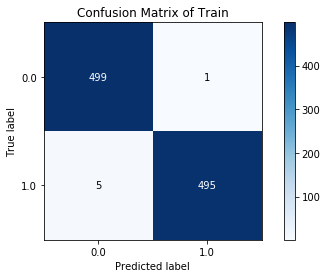

In [23]:
# Train Confusion Matrix
skplt.metrics.plot_confusion_matrix(y_true=y_train,
                                    y_pred=pred_train,
                                    title='Confusion Matrix of Train',
                                    normalize=False,
                                    figsize=(8,4))

In [24]:
# Train Classification Report
print(classification_report(y_train, pred_train))

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99       500
         1.0       1.00      0.99      0.99       500

   micro avg       0.99      0.99      0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000



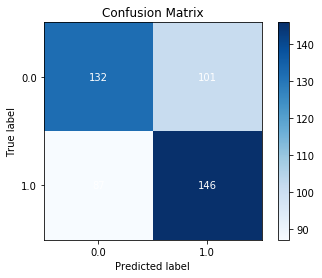

In [25]:
# Test Confusion Matrix
skplt.metrics.plot_confusion_matrix(y_true=y_test,
                                    y_pred=pred_test)

In [26]:
# Test Classification Report
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

         0.0       0.60      0.57      0.58       233
         1.0       0.59      0.63      0.61       233

   micro avg       0.60      0.60      0.60       466
   macro avg       0.60      0.60      0.60       466
weighted avg       0.60      0.60      0.60       466



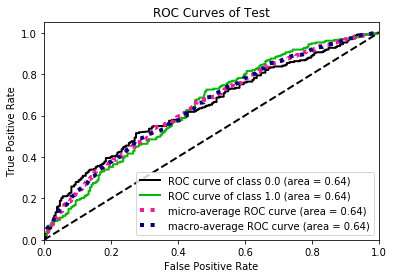

In [27]:
# Test ROC
skplt.metrics.plot_roc(y_true=y_test, 
                       y_probas=pred_test_prob, 
                       title='ROC Curves of Test')